In [1]:
!pip install opencv-python numpy ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
import cv2
import numpy as np
from ultralytics import YOLO
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 448MB/s]


In [4]:
class Utils:
    def __init__(self, video_path, model, confidence_threshold = 0):
        self.video_path = video_path #'test.mp4'
        self.model = model
        self.confidence_threshold = confidence_threshold

    def get_frame(self, frame_id):
        cap = cv2.VideoCapture(self.video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
        # Read the frame
        ret, frame = cap.read()
        return frame

    def detect_balls(self, frame):
        # Run YOLO detection
        results = self.model(frame, classes=[32], verbose=False)  # class 32 is 'sports ball' in COCO dataset

        # Filter for billiard balls (you may need to fine-tune this)
        balls = []
        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = float(box.conf[0])
                if conf > self.confidence_threshold:  # confidence threshold
                    balls.append({
                        'bbox': (x1, y1, x2, y2),
                        'center': ((x1 + x2) // 2, (y1 + y2) // 2),
                        'confidence': conf
                    })
        return balls

    def distance(self, p1, p2):
        x1, y1 = p1
        x2, y2 = p2
        return int(np.sqrt((x1 - x2)**2 + (y1 - y2)**2))

    def interpolation(self, p1, p2, n_frames):
        x1, y1 = p1
        x2, y2 = p2
        x_steps = (x2 - x1) / n_frames
        y_steps = (y2 - y1) / n_frames
        return [(int(x1 + i*x_steps), int(y1 + i*y_steps)) for i in range(n_frames)]

    def show_image(self, frame):
        plt.imshow(frame)


utils = Utils('test.mp4', model)

# ========TESTING========
# frame = utils.get_frame(4)
# print(type(frame), frame.shape)

# balls = utils.detect_balls(frame)
# print(len(balls))

# utils.show_image(frame)

In [5]:
def process_video_get_pos(input_path):
    cap = cv2.VideoCapture(input_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    data = {'frames': [], 'pos': []}

    pbar = tqdm()
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Detect and classify balls
        pos = utils.detect_balls(frame)
        data['frames'].append(frame)
        data['pos'].append(pos)
        pbar.update(1)

    cap.release()
    pbar.close()
    return data

# Process test1 video
data = process_video_get_pos('test.mp4')

306it [02:08,  2.37it/s]


In [19]:
import pandas as pd
pos = data['pos']
max_balls = max([len(i) for i in pos])
pos_df = pd.DataFrame(index = range(len(data['frames'])), columns = [i for i in range(max_balls)])
# pos_df = pd.DataFrame(index = range(len(data['frames'])), columns = [i for i in range(4)])
pos_df

,0,1,2,3,4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
301,NaN,NaN,NaN,NaN,NaN
302,NaN,NaN,NaN,NaN,NaN
303,NaN,NaN,NaN,NaN,NaN
304,NaN,NaN,NaN,NaN,NaN


True

In [26]:
def predict_next_approx_linear(x, y):
    assert len(x) >= 1 and len(y) >= 1, 'Should have atleast 1 element'
    assert len(x) == len(y), 'Both should have 1 length'
    if len(y) == 1:
        return y[0]
    elif len(y) >= 2:
        x = np.array(x)
        y = np.array(y)
        m, c = np.polyfit(x, y, 1)
        return m * (x[-1] + 1) + c
    else:
        return None

predict_next_approx_linear([4,5],[1,2])

np.float64(3.0000000000000004)

In [13]:
def ball_tracking(frame_positions):
    last_pos = {}
    past_n_frames = 5
    for p_ind, pos in tqdm(enumerate(frame_positions)):
        if p_ind == 0:
            for ind, p in enumerate(pos):
                pos_df.loc[p_ind, ind] = p['center']
            continue
        else:
            for ball_id in range(max_balls):
                p = pos_df.iloc[max(p_ind - past_n_frames, 0): p_ind, ball_id].to_list()
                ind = [_ind for _ind, val in enumerate(p) if isinstance(val, tuple)]
                x = [i[0] for i in p if isinstance(i, tuple)]
                y = [i[1] for i in p if isinstance(i, tuple)]
                pos_df.loc[p_ind, ball_id] = (int(predict_next_approx_linear(ind, x)),
                                              int(predict_next_approx_linear(ind, y)))
            for ind, p in enumerate(pos):
                tracking = []
                for ball_id in range(4):
                    d = utils.distance(p['center'], pos_df.loc[p_ind, ball_id])
                    tracking.append((ball_id, d, p['center'], p['bbox']))
                d_lst = [d for bi, d, p, bb in tracking]
                min_ind = d_lst.index(min(d_lst))
                bi = tracking[min_ind][0]
                p1 = tracking[min_ind][2]
                pos_df.loc[p_ind, min_ind] = p1
        else:
            for ind, p in enumerate(pos):
                tracking = []
                for last_ball_ind, last_ball_pos in last_pos.items():
                    d = utils.distance(p['center'], last_ball_pos)
                    tracking.append((last_ball_ind, d, p['center'], p['bbox']))
                d_lst = [d for bi, d, p, bb in tracking]
                min_ind = d_lst.index(min(d_lst))
                bi = tracking[min_ind][0]
                p1 = tracking[min_ind][2]
                bb = tracking[min_ind][3]
                # pos_df.loc[pind, min_ind] = bb
                pos_df.loc[pind, min_ind] = p1
                last_pos[min_ind] = p1

ball_tracking(pos)

269it [00:00, 752.92it/s]


In [14]:
# for last_ball_ind, last_ball_pos in last_pos.items():
#     d = utils.distance(p['center'], last_ball_pos)
#     tracking.append((last_ball_ind, d, p['center'], p['bbox']))
# d_lst = [d for bi, d, p, bb in tracking]
# min_ind = d_lst.index(min(d_lst))
# bi = tracking[min_ind][0]
# p1 = tracking[min_ind][2]
# bb = tracking[min_ind][3]
# # pos_df.loc[pind, min_ind] = bb
# pos_df.loc[pind, min_ind] = p1
# last_pos[min_ind] = p1
# return

# ball_tracking(poss)

In [15]:
pos_df.tail(200).head(50)

,0,1,2,3
69,"(767, 1304)","(3155, 1279)",NaN,NaN
70,"(790, 1303)","(3155, 1279)",NaN,NaN
71,"(818, 1306)","(3156, 1279)",NaN,NaN
72,"(1952, 1279)","(3155, 1279)",NaN,NaN
73,"(1952, 1279)","(3156, 1279)",NaN,NaN
74,"(899, 1304)","(3156, 1279)",NaN,NaN
75,"(1952, 1279)","(3156, 1279)",NaN,NaN
76,"(988, 1305)","(3156, 1278)",NaN,NaN
77,"(1051, 1301)","(3156, 1278)",NaN,NaN
78,"(1952, 1279)","(3156, 1279)",NaN,NaN


In [16]:
# def interpolation():
#     for col in pos_df.columns:
#         vals = pos_df[col].to_list()
#         new_op = vals.copy()
#         start, n_frames = 0,0
#         for ind, p in enumerate(vals):
#             if start == None and isinstance(p, tuple):
#                 start = p
#                 continue
#             if not isinstance(p, tuple) and math.isnan(p):
#                 n_frames += 1
#             elif isinstance(p, tuple) and n_frames > 0:
#                 x1, y1 = start
#                 x2, y2 = p
#                 x_steps = (x2 - x1) / n_frames
#                 y_steps = (y2 - y1) / n_frames
#                 new_op = new_op[:ind - n_frames] + \
#                     [(int(x1 + i*x_steps), int(y1 + i*y_steps)) for i in range(n_frames)] + \
#                     new_op[ind:]
#                 # ip1 = np.linspace(start[0], p[0], num=n_frames, endpoint=True, dtype=int, axis=0)
#                 # ip2 = np.linspace(start[1], p[1], num=n_frames, endpoint=True, dtype=int, axis=0)
#                 # ip3 = np.linspace(start[2], p[2], num=n_frames, endpoint=True, dtype=int, axis=0)
#                 # ip4 = np.linspace(start[3], p[3], num=n_frames, endpoint=True, dtype=int, axis=0)
#                 # new_op = new_op[:ind - n_frames] + \
#                 #     [(i,j,k,l) for i,j,k,l in zip(ip1, ip2, ip3, ip4)] + \
#                 #     new_op[ind:]
#                 n_frames = 0
#                 start = p
#             elif p != None and n_frames == 0:
#                 start = p
#         pos_df[col] = new_op

# interpolation()

In [152]:
pos_df.tail(200).head(50)

,0,1,2,3
106,"(1122, 390)","(572, 368)","(754, 381)","(93, 352)"
107,"(1123, 390)","(573, 368)","(741, 380)","(93, 352)"
108,"(1123, 389)","(573, 367)","(731, 380)","(94, 352)"
109,"(1124, 389)","(573, 367)","(719, 378)","(94, 351)"
110,"(1124, 389)","(574, 367)","(710, 378)","(95, 351)"
111,"(1125, 388)","(574, 366)","(697, 377)","(95, 350)"
112,"(1126, 388)","(575, 366)","(686, 376)","(95, 349)"
113,"(1126, 387)","(575, 365)","(675, 375)","(95, 348)"
114,"(1127, 387)","(576, 365)","(663, 374)","(95, 347)"
115,"(1128, 387)","(576, 364)","(651, 372)","(95, 345)"


In [17]:
total_x, total_y = [], []
def get_std():
    for col in pos_df.columns:
        vals = [i for i in pos_df[col] if isinstance(i, tuple)]
        x = [i[0] for i in vals]
        y = [i[1] for i in vals]
        total_x.extend(x)
        total_y.extend(y)
        print(np.std(x), np.std(y))

get_std()

1278.2312131776878 91.20684909367218
586.1832372275616 30.096220811783702
nan nan
nan nan


/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [18]:
mean_std_x, mean_std_y = np.std(total_x), np.std(total_y)
mean_std_x, mean_std_y

(np.float64(1297.3504425771614), np.float64(69.17777385747702))

In [19]:
def transform(col):
    vals = [i for i in pos_df[col] if isinstance(i, tuple)]
    x = [i[0] for i in vals]
    y = [i[1] for i in vals]
    return True if np.std(x) > 0.5 * mean_std_x else False

ball_mapping = {ball_id: transform(ball_id) for ball_id in range(4)}
ball_mapping

{0: True, 1: False, 2: False, 3: False}

In [23]:
# =======================VERSION-1===========================

# def ball_tracking(poss):
#     balls = {}
#     for pind, pos in tqdm(enumerate(poss)):
#         neartes_match = False
#         if pind == 0:
#             for ind, p in enumerate(pos):
#                 balls.setdefault(ind, [])
#                 balls[ind].append(p['center'])
#             continue
#         else:
#             for p in pos:
#                 tracking = []
#                 for ball_ind, ball_pos_lst in balls.items():
#                     d = utils.distance(p['center'], ball_pos_lst[-1])
#                     tracking.append((ball_ind, d, p['center']))
#                 d_lst = [d for bi, d, p in tracking]
#                 min_ind = d_lst.index(min(d_lst))
#                 bi = tracking[min_ind][0]
#                 p1 = tracking[min_ind][2]
#                 if len(balls[bi]) < pind:
#                     # balls[bi].extend([p1] * (pind - len(balls[bi])))
#                     balls[bi].extend(utils.interpolation(balls[min_ind][-1], p1, pind - len(balls[bi])))
#                 balls[bi].append(p1)


#     return balls

# balls = ball_tracking(poss)

269it [00:00, 50277.07it/s]


In [21]:
pos_df.shape

(269, 4)

In [22]:
# =======================VERSION-2===========================

def process_video_with_yolo(input_path, output_path):
    cap = cv2.VideoCapture(input_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_no = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Draw stationary balls (red bounding boxes)
        for ball_no in range(4):
            print(frame_no, ball_no, pos_df.loc[frame_no, ball_no])
            try:
                x, y = pos_df.loc[frame_no, ball_no]
                cv2.rectangle(frame, (x-5, y-5), (x+5, y+5), (0, 0, 255), 2)
                if ball_mapping[ball_no]:
                    cv2.putText(frame, f"ID {ball_no} | ACTION", (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                else:
                    cv2.putText(frame, f"ID {ball_no} | STATIONARY", (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            except:
                pass
        frame_no += 1

        out.write(frame)

    cap.release()
    out.release()
    return data

# Process test1 video
data = process_video_with_yolo('test2.mp4', 'output_test5.mp4')

0 0 (438, 1297)
0 1 (1952, 1280)
0 2 nan
0 3 nan
1 0 (438, 1298)
1 1 (1952, 1279)
1 2 nan
1 3 nan
2 0 (438, 1298)
2 1 (1952, 1279)
2 2 nan
2 3 nan
3 0 (437, 1298)
3 1 (1952, 1279)
3 2 nan
3 3 nan
4 0 (436, 1298)
4 1 (1952, 1279)
4 2 nan
4 3 nan
5 0 (435, 1298)
5 1 (1952, 1279)
5 2 nan
5 3 nan
6 0 (434, 1298)
6 1 (1952, 1279)
6 2 nan
6 3 nan
7 0 (434, 1297)
7 1 (1952, 1279)
7 2 nan
7 3 nan
8 0 (433, 1298)
8 1 (1952, 1279)
8 2 nan
8 3 nan
9 0 (431, 1298)
9 1 (1952, 1279)
9 2 nan
9 3 nan
10 0 (431, 1298)
10 1 (1952, 1279)
10 2 nan
10 3 nan
11 0 (431, 1297)
11 1 (1952, 1279)
11 2 nan
11 3 nan
12 0 (430, 1298)
12 1 (3156, 1279)
12 2 nan
12 3 nan
13 0 (429, 1298)
13 1 (3156, 1278)
13 2 nan
13 3 nan
14 0 (1953, 1279)
14 1 (3517, 1278)
14 2 nan
14 3 nan
15 0 (1953, 1279)
15 1 (3155, 1279)
15 2 nan
15 3 nan
16 0 (1953, 1279)
16 1 (3817, 1278)
16 2 nan
16 3 nan
17 0 (1952, 1279)
17 1 (3756, 1278)
17 2 nan
17 3 nan
18 0 (1953, 1279)
18 1 (3930, 1278)
18 2 nan
18 3 nan
19 0 (1952, 1279)
19 1 (3155

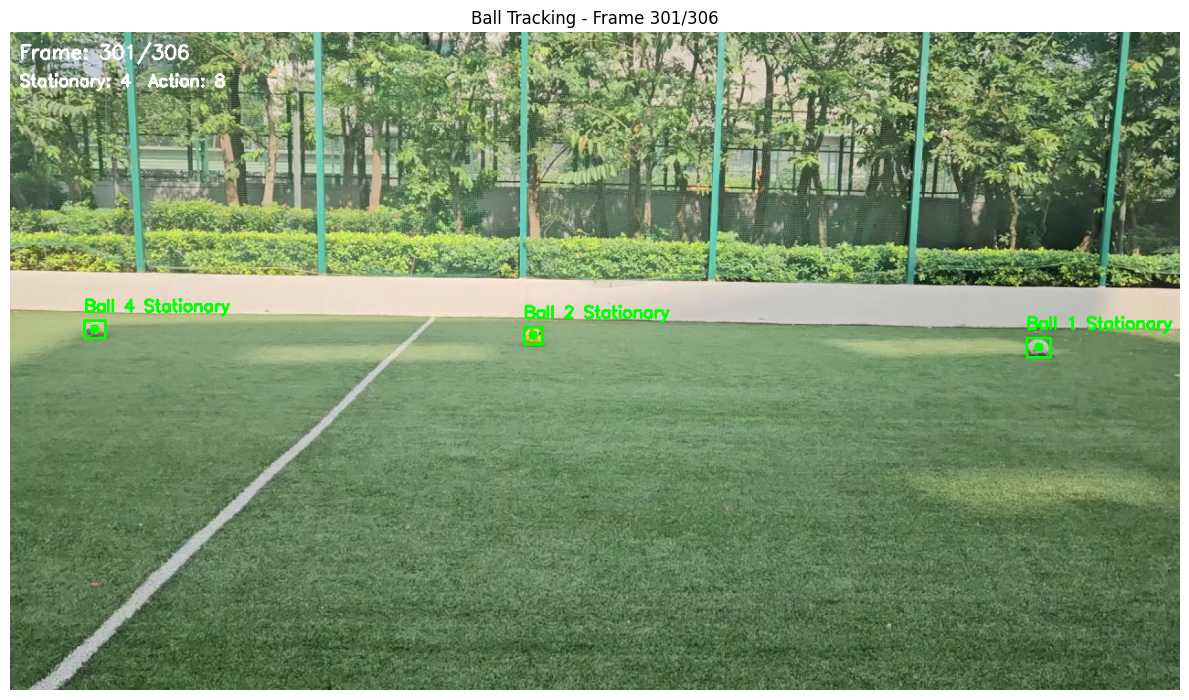

Processing complete!
Final ball classifications: {'1': 'stationary', '2': 'stationary', '3': 'stationary', '4': 'stationary', '9': 'action', '13': 'action', '15': 'action', '17': 'action', '18': 'action', '19': 'action', '23': 'action', '24': 'action'}


In [109]:
# import cv2
# import numpy as np
# from ultralytics import YOLO
# import math
# from collections import defaultdict, deque
# import matplotlib.pyplot as plt
# from IPython.display import clear_output
# from deep_sort_realtime.deepsort_tracker import DeepSort
# import networkx as nx
# from sklearn.metrics.pairwise import cosine_similarity

# class Track:
#     def __init__(self, track_id, frames, bboxes, features):
#         self.id = track_id
#         self.frames = frames          # list of ints
#         self.bboxes = bboxes          # list of [x1,y1,x2,y2]
#         self.features = features      # list of np.arrays

#     def start(self):
#         return min(self.frames)

#     def end(self):
#         return max(self.frames)

#     def temporal_overlap(self, other, max_gap=5):
#         latest_start = max(self.start(), other.start())
#         earliest_end = min(self.end(), other.end())
#         if earliest_end >= latest_start:
#             return True
#         gap = max(other.start() - self.end(), self.start() - other.end())
#         return gap <= max_gap

#     def spatial_similarity(self, other, iou_thresh=0.3):
#         common_frames = set(self.frames).intersection(set(other.frames))
#         if len(common_frames) == 0:
#             return False
#         ious = []
#         for f in common_frames:
#             idx1 = self.frames.index(f)
#             idx2 = other.frames.index(f)
#             iou_val = BallTracker.compute_iou(self.bboxes[idx1], other.bboxes[idx2])
#             ious.append(iou_val)
#         avg_iou = np.mean(ious)
#         return avg_iou >= iou_thresh

#     def appearance_similarity(self, other, thresh=0.7):
#         common_frames = set(self.frames).intersection(set(other.frames))
#         if len(common_frames) == 0:
#             return False
#         feats1 = [self.features[self.frames.index(f)] for f in common_frames]
#         feats2 = [other.features[other.frames.index(f)] for f in common_frames]
#         sim = BallTracker.avg_cosine_similarity(feats1, feats2)
#         return sim >= thresh

# class BallTracker:
#     def __init__(self, model_path='yolov8m.pt', confidence_threshold=0.3):
#         self.model = YOLO(model_path)
#         self.confidence_threshold = confidence_threshold
#         self.tracker = DeepSort(max_age=10, n_init=3, polygon=False)
#         self.track_history = defaultdict(lambda: deque(maxlen=50))  # store (frame, bbox, feature)
#         self.ball_classifications = {}
#         self.stationary_frames = 10
#         self.stationary_threshold = 25
#         self.stationary_velocity_threshold = 2.0
#         self.frame_number = 0

#     @staticmethod
#     def compute_iou(boxA, boxB):
#         xA = max(boxA[0], boxB[0])
#         yA = max(boxA[1], boxB[1])
#         xB = min(boxA[2], boxB[2])
#         yB = min(boxA[3], boxB[3])
#         interArea = max(0, xB - xA) * max(0, yB - yA)
#         boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
#         boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
#         iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
#         return iou

#     @staticmethod
#     def avg_cosine_similarity(feats1, feats2):
#         if len(feats1) == 0 or len(feats2) == 0:
#             return 0
#         feats1 = np.stack(feats1)
#         feats2 = np.stack(feats2)
#         sim_matrix = cosine_similarity(feats1, feats2)
#         return np.mean(sim_matrix)

#     def detect_balls(self, frame_count):
#         # results = self.model(frame, conf=self.confidence_threshold, classes=[32])
#         # detections = []
#         # if results and len(results) > 0 and results[0].boxes is not None:
#         #     boxes = results[0].boxes.xyxy.cpu().numpy()
#         #     confs = results[0].boxes.conf.cpu().numpy()
#         #     for box, conf in zip(boxes, confs):
#         #         x1, y1, x2, y2 = box
#         #         detections.append([float(x1), float(y1), float(x2 - x1), float(y2 - y1)])
#         detections = []
#         for b in range(4):
#             val = pos_df.loc[frame_count, b]
#             if isinstance(val, tuple):
#                 x1, y1, x2, y2 = pos_df.loc[frame_count, b]
#                 detections.append(([float(x1), float(y1), float(x2 - x1), float(y2 - y1)], float(0.5)))
#         return detections

#     def update_tracks(self, detections, frame):
#         tracks = self.tracker.update_tracks(detections, frame=frame)
#         tracked_objects = []
#         # For each track, save bbox, frame number, and appearance feature (embedding)
#         for track in tracks:
#             if not track.is_confirmed():
#                 continue
#             track_id = track.track_id
#             l, t, r, b = map(int, track.to_ltrb())
#             cx, cy = (l + r) // 2, (t + b) // 2
#             # Save full bbox for merging
#             bbox = [l, t, r, b]
#             # Save embedding feature from tracker (if exists)
#             try:
#                 embedding = track.last_embedding  # numpy array or None
#                 if embedding is None:
#                     embedding = np.zeros(128)
#             except:
#                 embedding = np.zeros(128)
#             # Update track history with frame, bbox, and feature
#             self.track_history[track_id].append((self.frame_number, bbox, embedding))
#             tracked_objects.append({
#                 'track_id': track_id,
#                 'bbox': bbox,
#                 'center': (cx, cy),
#             })
#         return tracked_objects

#     def draw_overlays(self, frame, tracked_objects, frame_count):
#           overlay_frame = frame.copy()
#           for obj in tracked_objects:
#               track_id = obj['track_id']
#               bbox = obj['bbox']
#               center = obj['center']
#               classification = self.ball_classifications.get(track_id, 'unknown')
#               x1, y1, x2, y2 = bbox

#               if classification == 'stationary':
#                   cv2.rectangle(overlay_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
#                   cv2.putText(overlay_frame, f"Ball {track_id} Stationary", (x1, y1 - 10),
#                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
#                   cv2.circle(overlay_frame, center, 5, (0, 255, 0), -1)

#               elif classification == 'action':
#                   cv2.rectangle(overlay_frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
#                   cv2.putText(overlay_frame, f"Ball {track_id} Action", (x1, y1 - 10),
#                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
#                   cv2.circle(overlay_frame, center, 8, (0, 0, 255), -1)
#                   points = self.track_history[track_id]
#                   for i in range(1, len(points)):
#                     bbox_prev = points[i - 1][1]
#                     bbox_curr = points[i][1]
#                     pt1 = ((bbox_prev[0] + bbox_prev[2]) // 2, (bbox_prev[1] + bbox_prev[3]) // 2)
#                     pt2 = ((bbox_curr[0] + bbox_curr[2]) // 2, (bbox_curr[1] + bbox_curr[3]) // 2)
#                     cv2.line(overlay_frame, pt1, pt2, (0, 0, 255), 2)
#                   # for i in range(1, len(points)):
#                   #     cv2.line(overlay_frame, points[i - 1], points[i], (0, 0, 255), 2)
#               else:
#                   cv2.rectangle(overlay_frame, (x1, y1), (x2, y2), (255, 255, 0), 1)
#                   cv2.circle(overlay_frame, center, 4, (255, 255, 0), -1)
#                   cv2.putText(overlay_frame, f"Ball {track_id}...", (x1, y1 - 10),
#                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)
#           return overlay_frame

#     def classify_balls(self, tracked_objects):
#         for obj in tracked_objects:
#             track_id = obj['track_id']
#             center = obj['center']
#             points = self.track_history[track_id]
#             # Extract centers only for velocity classification
#             centers = [((b[0] + b[2]) // 2, (b[1] + b[3]) // 2) for _, b, _ in points]
#             if len(centers) >= 2:
#                 dx = centers[-1][0] - centers[-2][0]
#                 dy = centers[-1][1] - centers[-2][1]
#                 velocity = math.sqrt(dx * dx + dy * dy)
#                 if velocity > self.stationary_velocity_threshold:
#                     self.ball_classifications[track_id] = 'action'
#                 else:
#                     if len(centers) >= self.stationary_frames:
#                         total_movement = 0
#                         for i in range(-self.stationary_frames + 1, 0):
#                             total_movement += math.sqrt(
#                                 (centers[i][0] - centers[i - 1][0]) ** 2 +
#                                 (centers[i][1] - centers[i - 1][1]) ** 2
#                             )
#                         if total_movement < self.stationary_threshold:
#                             self.ball_classifications[track_id] = 'stationary'
#                         else:
#                             self.ball_classifications[track_id] = 'action'
#                     else:
#                         self.ball_classifications[track_id] = 'unknown'
#             else:
#                 self.ball_classifications[track_id] = 'unknown'

#     def merge_tracks_postprocess(self):
#         # Convert track_history to Track objects
#         tracks = []
#         for track_id, history in self.track_history.items():
#             frames = []
#             bboxes = []
#             features = []
#             for (frame_num, bbox, feat) in history:
#                 frames.append(frame_num)
#                 bboxes.append(bbox)
#                 features.append(feat)
#             tracks.append(Track(track_id, frames, bboxes, features))

#         # Build graph to find merges
#         G = nx.Graph()
#         for t in tracks:
#             G.add_node(t.id, track=t)

#         for i in range(len(tracks)):
#             for j in range(i + 1, len(tracks)):
#                 t1 = tracks[i]
#                 t2 = tracks[j]
#                 if self.should_merge_tracks(t1, t2):
#                     G.add_edge(t1.id, t2.id)

#         # Merge connected components
#         merged_tracks = []
#         new_id_map = {}
#         for component in nx.connected_components(G):
#             comp_tracks = [G.nodes[n]['track'] for n in component]
#             merged = self.combine_tracks(comp_tracks)
#             merged_tracks.append(merged)
#             # Map old IDs to new merged ID
#             for t in comp_tracks:
#                 new_id_map[t.id] = merged.id

#         # Update track_history and ball classifications with merged IDs
#         updated_history = defaultdict(lambda: deque(maxlen=50))
#         updated_classifications = {}

#         for old_id, new_id in new_id_map.items():
#             history = self.track_history[old_id]
#             for item in history:
#                 updated_history[new_id].append(item)

#         # For classification, keep max classification strength: action > unknown > stationary
#         for tid in updated_history:
#             statuses = []
#             for old_id, new_id in new_id_map.items():
#                 if new_id == tid and old_id in self.ball_classifications:
#                     statuses.append(self.ball_classifications[old_id])
#             # Priority assignment
#             if 'action' in statuses:
#                 updated_classifications[tid] = 'action'
#             elif 'unknown' in statuses:
#                 updated_classifications[tid] = 'unknown'
#             else:
#                 updated_classifications[tid] = 'stationary'

#         self.track_history = updated_history
#         self.ball_classifications = updated_classifications

#     def should_merge_tracks(self, t1, t2):
#         # Use same logic as previous example for merging
#         if not t1.temporal_overlap(t2):
#             return False
#         if not t1.spatial_similarity(t2):
#             return False
#         if not t1.appearance_similarity(t2):
#             return False
#         return True

#     def combine_tracks(self, tracks):
#         all_frames = []
#         all_bboxes = []
#         all_features = []
#         for t in tracks:
#             all_frames.extend(t.frames)
#             all_bboxes.extend(t.bboxes)
#             all_features.extend(t.features)

#         sorted_idxs = np.argsort(all_frames)
#         all_frames = [all_frames[i] for i in sorted_idxs]
#         all_bboxes = [all_bboxes[i] for i in sorted_idxs]
#         all_features = [all_features[i] for i in sorted_idxs]

#         unique_frames = []
#         unique_bboxes = []
#         unique_features = []

#         for i, f in enumerate(all_frames):
#             if i > 0 and f == all_frames[i - 1]:
#                 prev_area = (unique_bboxes[-1][2] - unique_bboxes[-1][0]) * (unique_bboxes[-1][3] - unique_bboxes[-1][1])
#                 curr_area = (all_bboxes[i][2] - all_bboxes[i][0]) * (all_bboxes[i][3] - all_bboxes[i][1])
#                 if curr_area > prev_area:
#                     unique_bboxes[-1] = all_bboxes[i]
#                     unique_features[-1] = all_features[i]
#             else:
#                 unique_frames.append(f)
#                 unique_bboxes.append(all_bboxes[i])
#                 unique_features.append(all_features[i])

#         merged_id = min(t.id for t in tracks)
#         return Track(merged_id, unique_frames, unique_bboxes, unique_features)

#     def display_frame_colab(self, frame, frame_count, total_frames):
#         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         clear_output(wait=True)
#         plt.figure(figsize=(12, 8))
#         plt.imshow(frame_rgb)
#         plt.title(f"Ball Tracking - Frame {frame_count + 1}/{total_frames}")
#         plt.axis('off')
#         plt.tight_layout()
#         plt.show()


#     # *** Keep your other methods unchanged (classify_balls, draw_overlays, display_frame_colab, process_video, etc.) ***

#     # Update process_video to call merge postprocess every N frames or at the end
#     def process_video(self, video_path, output_path=None, display_interval=30, colab_display=True, merge_interval=50):
#         cap = cv2.VideoCapture(video_path)
#         if not cap.isOpened():
#             print(f"Error: Could not open video {video_path}")
#             return
#         fps = int(cap.get(cv2.CAP_PROP_FPS))
#         width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#         height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#         total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#         if output_path:
#             fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#             out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
#         frame_count = 0

#         print(f"Processing video: {video_path}")
#         print(f"Total frames: {total_frames}, FPS: {fps}")
#         print(f"Display interval: Every {display_interval} frames")
#         while True:
#             ret, frame = cap.read()
#             if not ret:
#                 break
#             self.frame_number = frame_count

#             detections = self.detect_balls(frame_count)
#             tracked_objects = self.update_tracks(detections, frame)
#             self.classify_balls(tracked_objects)

#             # Merge fragmented tracks every `merge_interval` frames
#             if frame_count > 0 and frame_count % merge_interval == 0:
#                 self.merge_tracks_postprocess()

#             overlay_frame = self.draw_overlays(frame, tracked_objects, frame_count)
#             info_text = f"Frame: {frame_count + 1}/{total_frames}"
#             cv2.putText(overlay_frame, info_text, (10, 30),
#                         cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
#             stationary_count = sum(c == 'stationary' for c in self.ball_classifications.values())
#             action_count = sum(c == 'action' for c in self.ball_classifications.values())
#             cv2.putText(overlay_frame, f"Stationary: {stationary_count}  Action: {action_count}", (10, 60),
#                         cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
#             if output_path:
#                 out.write(overlay_frame)
#             if colab_display and (frame_count % display_interval == 0 or frame_count == 0):
#                 self.display_frame_colab(overlay_frame, frame_count, total_frames)
#             frame_count += 1
#             if frame_count % 30 == 0:
#                 print(f"Processed {frame_count}/{total_frames} frames")

#         # Final merge after processing all frames
#         self.merge_tracks_postprocess()

#         cap.release()
#         if output_path:
#             out.release()
#         print("Processing complete!")
#         print(f"Final ball classifications: {self.ball_classifications}")

#     # Keep your existing methods like draw_overlays(), display_frame_colab(), etc.

# # Existing main() remains unchanged; just instantiate BallTracker as before.

# def main():
#     test_videos = ['/content/test.mp4']  # Update with your video files
#     for video_path in test_videos:
#         print("=" * 50)
#         print(f"Processing {video_path}")
#         print("=" * 50)
#         tracker = BallTracker(confidence_threshold=0.3)
#         video_name = video_path.split('/')[-1]  # e.g., 'test.mp4'
#         output_path = f"/content/tracked_{video_name}"
#         tracker.process_video(
#             video_path,
#             output_path=output_path,
#             display_interval=30,
#             colab_display=True
#         )

# if __name__ == "__main__":
#     main()